# Animating Complete NBA Games with matplotlib and pandas

In this notebook, we will explore pulling shot positional data from the NBA's undocumented API and then animating entire games with matplotlib one shot at a time. 
### Motivation
If you are unfamiliar with what is meant by 'shot positional data', let's first take a look at an example below of the last game played between the Cleveland Cavaliers and the Golden State Warriors on June 13, 2016 pulled directly from the excellent basketball data website [basketballreference.com](http://www.basketballreference.com).

In [1]:
'''
baseketballreference.com creates nifty little visualizations of each shot taken by each team.

To inject the basketballreference shot visualizations we can take advantage of the IPython.display module. 
Here we simply insert an iframe (of a particularl part of the game page) directly into the ipython notebook
'''
from IPython.display import HTML
HTML('<iframe src=http://www.basketball-reference.com/boxscores/shot-chart/201606130GSW.html#shot_chart-CLE width=1050 height=600 scrolling="no"></iframe>')

# Practice through Replication
This visual looks quite good and a good challenge would be to attempt to replicate it in python's visualization library matplotlib. To start, we need to get the exact court positions for all shots and whether the shot was made or not. We could try scraping the web page above but this seems a bit too manual.

## Using an API
It's usally a good idea to search for an easier more direct way of extracting the data than by manually scraping if possible. It turns out, the NBA has an unofficial API that was reverse engineered in a fantastic [blog post by Greg Reda](http://www.gregreda.com/2015/02/15/web-scraping-finding-the-api/). The post is an excellent read on how to discover an API with your browser's developer tools.

## API Documentation
Althought no official documentation of the NBA stats API exists to my knowledge, some helpful endpoint documentation [can be found here](https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation)

## Accessing the correct endpoint
All the NBA API endpoints can be accessed via **`stats.nba.com/stats/<specific endpoint>?<list of paramters>`**. By using the endpoint documentation above we can get all shots from a specific game using the **shotchartdetail** endpoint. All parameters must be present in the API request url even if they do not take a value. As there is no official documentation it will take some hacking around to get the results that are needed.

## GameID
The most important parameter in the url below is **GameID** which (for now) will have to be manually retreived by visiting **stats.nba.com** and finding the game you are interested in. You should come across the GameID by looking at the [box score of a game](http://stats.nba.com/game/#!/0041500405/).

In [2]:
'''
most recent Cleveland vs Golden State Game
'''
game_id = '0041500405'

## Build URL
From the API documentaion, you can experimentally build a URL that can be used to retrieve results

In [3]:
'''
Build the URL by writing out all the parameters for the endpoint
.format replaces the curl braces {} with the value of game_id
'''
SHOT_CHART_URL = 'http://stats.nba.com/stats/shotchartdetail?ContextFilter='\
        '&ContextMeasure=FGA&DateFrom=&DateTo=&GameID={}&GameSegment=&LastNGames=0&LeagueID=00'\
        '&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame' \
        '&Period=0&PlayerID=0&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2015-16&SeasonSegment='\
        '&SeasonType=Playoffs&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0'\
        '&showShots=1&showZones=0'.format(game_id);

In [4]:
SHOT_CHART_URL

'http://stats.nba.com/stats/shotchartdetail?ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=0041500405&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=0&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2015-16&SeasonSegment=&SeasonType=Playoffs&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0'

## If you get an error below
In the very next block of code, it is possible to get an error. Please copy and paste the SHOT_CHART_URL from above and paste it into your browser. You should be able to see the response as a long mess of basketball data. You may have to do this multiple times

## Retreive data using requests library
The third party requests library provides very easy syntax to retreive http requests.

In [5]:
'''
Use requests library to issue get request. 
Use json method to turn response into python dictionary
'''
import requests
response = requests.get(SHOT_CHART_URL)
data = response.json()

In [6]:
'''
Inspect data, which is now a python dictionary
'''
data.keys()

dict_keys(['resource', 'resultSets', 'parameters'])

In [7]:
data['resource']

'shotchartdetail'

In [8]:
'''
Take a look at the parameters passed to the get request
'''
data['parameters']

{'AheadBehind': None,
 'ClutchTime': None,
 'ContextFilter': '',
 'ContextMeasure': 'FGA',
 'DateFrom': None,
 'DateTo': None,
 'EndPeriod': None,
 'EndRange': None,
 'GameID': '0041500405',
 'GameSegment': None,
 'LastNGames': 0,
 'LeagueID': '00',
 'Location': None,
 'Month': 0,
 'OpponentTeamID': 0,
 'Outcome': None,
 'Period': 0,
 'PlayerID': 0,
 'PointDiff': None,
 'Position': None,
 'RangeType': None,
 'RookieYear': None,
 'Season': '2015-16',
 'SeasonSegment': None,
 'SeasonType': 'Playoffs',
 'StartPeriod': None,
 'StartRange': None,
 'TeamID': 0,
 'VsConference': None,
 'VsDivision': None}

## Here comes pandas
pandas is a fantastic library to manipulate, summarize and transform tabular (row/column) data. After some inspecting it appears that the tabular data is stored in the **resultsSets** key. There are two datasets returned. A small dataset that summarizes (I call it **df_summary**) all of the shots taken and much larger data set that contains very detailed data on each attempted shot (which I call **df_shots**)

In [9]:
'''
bring pandas into the namespace and alias it to pd as is convention
'''
import pandas as pd

In [10]:
data['resultSets'][0].keys()

dict_keys(['name', 'headers', 'rowSet'])

In [11]:
column_data = data['resultSets'][0]['rowSet']
column_names = data['resultSets'][0]['headers']

In [12]:
'''
The primary pandas object is the DataFrame, which contains the tabular data and comes with a
huge supply of methods that act on your data
'''
df_shots = pd.DataFrame(column_data, columns=column_names)

In [13]:
'''
Create another DataFrame for the less important summary data set
'''
column_data = data['resultSets'][1]['rowSet']
column_names = data['resultSets'][1]['headers']
df_summary = pd.DataFrame(column_data, columns=column_names)

In [14]:
'''
Inspect the top of the summary DataFrame
'''
df_summary.head()

,GRID_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,FGA,FGM,FG_PCT
0,League Averages,Above the Break 3,Back Court(BC),Back Court Shot,3,1,0.333
1,League Averages,Above the Break 3,Center(C),24+ ft.,800,260,0.325
2,League Averages,Above the Break 3,Left Side Center(LC),24+ ft.,1217,418,0.343
3,League Averages,Above the Break 3,Right Side Center(RC),24+ ft.,1113,408,0.367
4,League Averages,Backcourt,Back Court(BC),Back Court Shot,38,0,0.000


In [15]:
'''
Get some summary statistics on a single column
'''
df_shots['ACTION_TYPE'].value_counts().head()

Jump Shot             74
Pullup Jump shot      29
Layup Shot            14
Driving Layup Shot     8
Fadeaway Jump Shot     6
Name: ACTION_TYPE, dtype: int64

In [16]:
'''
Take a look at all the columns in the df_shots DataFrame
'''
df_shots.columns

Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG'],
      dtype='object')

In [17]:
'''
Inspect the top of the df_shots DataFrame
'''
df_shots.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,Shot Chart Detail,0041500405,4,2738,Andre Iguodala,1610612744,Golden State Warriors,1,11,24,...,Running Finger Roll Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-2,21,1,1
1,Shot Chart Detail,0041500405,5,202681,Kyrie Irving,1610612739,Cleveland Cavaliers,1,11,8,...,Pullup Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,25,-9,259,1,1
2,Shot Chart Detail,0041500405,6,202691,Klay Thompson,1610612744,Golden State Warriors,1,10,49,...,Pullup Jump shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,22,-228,-6,1,0
3,Shot Chart Detail,0041500405,8,2544,LeBron James,1610612739,Cleveland Cavaliers,1,10,36,...,Turnaround Fadeaway shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,11,-112,31,1,0
4,Shot Chart Detail,0041500405,10,201939,Stephen Curry,1610612744,Golden State Warriors,1,10,25,...,Pullup Jump shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,25,195,164,1,1


In [18]:
'''
Using the iloc operator, grab the first row.
iloc stands for integer location and is a verbose way of grabbing a particular row of a data frame
by its integer location
'''
df_shots.iloc[0]

GRID_TYPE                           Shot Chart Detail
GAME_ID                                    0041500405
GAME_EVENT_ID                                       4
PLAYER_ID                                        2738
PLAYER_NAME                            Andre Iguodala
TEAM_ID                                    1610612744
TEAM_NAME                       Golden State Warriors
PERIOD                                              1
MINUTES_REMAINING                                  11
SECONDS_REMAINING                                  24
EVENT_TYPE                                  Made Shot
ACTION_TYPE            Running Finger Roll Layup Shot
SHOT_TYPE                              2PT Field Goal
SHOT_ZONE_BASIC                       Restricted Area
SHOT_ZONE_AREA                              Center(C)
SHOT_ZONE_RANGE                       Less Than 8 ft.
SHOT_DISTANCE                                       2
LOC_X                                              -2
LOC_Y                       

## Missing Free Throws
After inspecting all of the **ACTION_TYPE** in the df_shots DataFrame it seems that free throws are missing from our data. To find the free throws, we turn to the **playbyplayv2** endpoint

In [19]:
PLAY_BY_PLAY_URL = 'http://stats.nba.com/stats/playbyplayv2?EndPeriod=10&EndRange=55800&GameID={}'\
                    '&RangeType=2&Season=2015-16&SeasonType=Playoffs&StartPeriod=1&StartRange=0'.format(game_id);

In [20]:
PLAY_BY_PLAY_URL

'http://stats.nba.com/stats/playbyplayv2?EndPeriod=10&EndRange=55800&GameID=0041500405&RangeType=2&Season=2015-16&SeasonType=Playoffs&StartPeriod=1&StartRange=0'

## If you get an error below
In the very next block of code, it is possible to get an error. Please copy and paste the PLAY_BY_PLAY_URL from above and paste it into your browser. You should be able to see the response as a long mess of basketball data. You may have to do this multiple times

In [21]:
'''
Retreive play by play data
'''
pbp_response = requests.get(PLAY_BY_PLAY_URL)
pbp_data = pbp_response.json()

In [22]:
column_data = pbp_data['resultSets'][0]['rowSet']
column_names = pbp_data['resultSets'][0]['headers']
df_play_by_play = pd.DataFrame(column_data, columns=column_names)

In [23]:
df_play_by_play.head()

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION
0,0041500405,0,12,0,1,9:11 PM,12:00,None,None,None,...,None,None,None,0,0,None,NaN,None,None,None
1,0041500405,1,10,0,1,9:11 PM,12:00,Jump Ball Bogut vs. Thompson: Tip to Curry,None,None,...,Cleveland,Cavaliers,CLE,4,201939,Stephen Curry,1.610613e+09,Golden State,Warriors,GSW
2,0041500405,2,5,45,1,9:12 PM,11:44,Bogut Out of Bounds - Bad Pass Turnover Turnov...,None,None,...,None,None,None,1,0,None,NaN,None,None,None
3,0041500405,3,5,41,1,9:12 PM,11:30,Iguodala STEAL (1 STL),None,James Poss Lost Ball Turnover (P1.T1),...,Golden State,Warriors,GSW,0,0,None,NaN,None,None,None
4,0041500405,4,1,76,1,9:12 PM,11:24,Iguodala 2' Running Finger Roll Layup (2 PTS),None,None,...,None,None,None,0,0,None,NaN,None,None,None


In [24]:
'''
Take a look at one row
'''
df_play_by_play.iloc[3]

GAME_ID                                                 0041500405
EVENTNUM                                                         3
EVENTMSGTYPE                                                     5
EVENTMSGACTIONTYPE                                              41
PERIOD                                                           1
WCTIMESTRING                                               9:12 PM
PCTIMESTRING                                                 11:30
HOMEDESCRIPTION                             Iguodala STEAL (1 STL)
NEUTRALDESCRIPTION                                            None
VISITORDESCRIPTION           James Poss Lost Ball Turnover (P1.T1)
SCORE                                                         None
SCOREMARGIN                                                   None
PERSON1TYPE                                                      5
PLAYER1_ID                                                    2544
PLAYER1_NAME                                          LeBron J

In [25]:
'''
EVENTMSGTYPE looks like it corresponds with the type of play. 
After some investigating (not show here), it appears that event type 3 is used only for free throws
'''
df_play_by_play['EVENTMSGTYPE'].value_counts()

4     111
2      95
1      76
8      59
3      49
6      43
5      33
9      14
18      5
13      4
12      4
10      3
7       2
Name: EVENTMSGTYPE, dtype: int64

In [26]:
'''
Create a DataFrame only for free throws.
Use boolean selection to get only event type 3
'''
df_ft_only = df_play_by_play[df_play_by_play['EVENTMSGTYPE'] == 3]

## Converting the free throw DataFrame to match the shot DataFrame
Since the **playbyplayv2** endpoint returns completely different data than the **shotchartdetail** endpoint we must create from scratch a new DataFrame for the free throws that mirrors exactly the **df_shots** DataFrame

In [27]:
'''
Use a single row of df_shots as a guide to creating the new DataFrame for free throws
'''
df_shots.iloc[0]

GRID_TYPE                           Shot Chart Detail
GAME_ID                                    0041500405
GAME_EVENT_ID                                       4
PLAYER_ID                                        2738
PLAYER_NAME                            Andre Iguodala
TEAM_ID                                    1610612744
TEAM_NAME                       Golden State Warriors
PERIOD                                              1
MINUTES_REMAINING                                  11
SECONDS_REMAINING                                  24
EVENT_TYPE                                  Made Shot
ACTION_TYPE            Running Finger Roll Layup Shot
SHOT_TYPE                              2PT Field Goal
SHOT_ZONE_BASIC                       Restricted Area
SHOT_ZONE_AREA                              Center(C)
SHOT_ZONE_RANGE                       Less Than 8 ft.
SHOT_DISTANCE                                       2
LOC_X                                              -2
LOC_Y                       

In [28]:
'''
Start with a dictionary that has the same keys (column names) as df_shots
Then loop through the free throw DataFrame to find the corresponding column that aligns
with df_shots
'''
ft_new_dict = {val:[] for val in df_shots.iloc[0].index.values}
for idx, row in df_ft_only.iterrows():
    ft_new_dict['GAME_ID'].append(row['GAME_ID'])
    ft_new_dict['GRID_TYPE'].append('Shot Chart Detail')
    ft_new_dict['GAME_EVENT_ID'].append(-1)
    ft_new_dict['PLAYER_NAME'].append(row['PLAYER1_NAME'])
    ft_new_dict['PLAYER_ID'].append(row['PLAYER1_ID'])
    ft_new_dict['TEAM_ID'].append(int(row['PLAYER1_TEAM_ID']))
    ft_new_dict['TEAM_NAME'].append(row['PLAYER1_TEAM_CITY'] + ' ' + row['PLAYER1_TEAM_NICKNAME'])
    ft_new_dict['PERIOD'].append(row['PERIOD'])
    min_remaining, sec_remaining = row['PCTIMESTRING'].split(':')
    ft_new_dict['MINUTES_REMAINING'].append(int(min_remaining))
    ft_new_dict['SECONDS_REMAINING'].append(int(sec_remaining))
    is_miss = 'MISS' in str(row['HOMEDESCRIPTION']) + str(row['VISITORDESCRIPTION'])
    ft_new_dict['EVENT_TYPE'].append('Missed Shot' if is_miss else 'Made Shot')
    ft_new_dict['ACTION_TYPE'].append('Free Throw')
    ft_new_dict['SHOT_TYPE'].append('Free Throw')
    ft_new_dict['SHOT_ZONE_BASIC'].append('Free Throw')
    ft_new_dict['SHOT_ZONE_AREA'].append('Free Throw')
    ft_new_dict['SHOT_ZONE_RANGE'].append('15 ft.')
    ft_new_dict['SHOT_DISTANCE'].append(15)
    ft_new_dict['LOC_X'].append(0)
    ft_new_dict['LOC_Y'].append(150)
    ft_new_dict['SHOT_ATTEMPTED_FLAG'].append(1)
    ft_new_dict['SHOT_MADE_FLAG'].append(0 if is_miss else 1)

'''
Finally, create the new data frame for free throws
'''
df_ft_final = pd.DataFrame(ft_new_dict)

In [29]:
'''
Combine the two data frames into one
'''
df_all = df_shots.append(df_ft_final, ignore_index=True)

In [30]:
'''
Add some columns for points and possible points
'''
df_all['POINTS_POSSIBLE'] = df_all['SHOT_TYPE'].map(lambda x: 1 if x[0] == 'F' else int(x[0]))
df_all['POINTS'] = df_all['POINTS_POSSIBLE'] * df_all['SHOT_MADE_FLAG']

## Does the data make sense
Lets do a sanity check, and calculate all the points that were scored in the game

In [31]:
'''
Create a new DataFrame that only has the points
'''
df_points = df_all.groupby(['TEAM_NAME', 'SHOT_TYPE'])['SHOT_MADE_FLAG', 'SHOT_ATTEMPTED_FLAG', 'POINTS'].agg('sum').reset_index()
df_points

,TEAM_NAME,SHOT_TYPE,SHOT_MADE_FLAG,SHOT_ATTEMPTED_FLAG,POINTS
0,Cleveland Cavaliers,2PT Field Goal,34,59,68
1,Cleveland Cavaliers,3PT Field Goal,10,24,30
2,Cleveland Cavaliers,Free Throw,14,23,14
3,Golden State Warriors,2PT Field Goal,18,45,36
4,Golden State Warriors,3PT Field Goal,14,43,42
5,Golden State Warriors,Free Throw,19,26,19


In [32]:
'''
The final score matches the acutal outcome so it looks like we are on track
'''
df_points.groupby('TEAM_NAME')['POINTS'].sum()

TEAM_NAME
Cleveland Cavaliers      112
Golden State Warriors     97
Name: POINTS, dtype: int64

## Visualization
Finally, lets work on visualizing our data. After some initial inspecting it is clear that columns LOC_X and LOC_Y contain the point on the court where the shot was taken. Let's visualize all the shots

In [33]:
'''
Bring in matplotlib's plotting module pyplot 
Very importantly use the ipython magic command %matplotlib inline to insure plots are created in the notebook itself
and not behind the scenes
'''
import matplotlib.pyplot as plt
%matplotlib inline

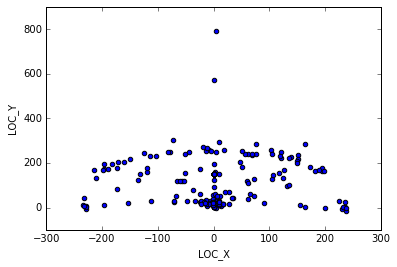

In [34]:
'''
A crude look at all the shots.
pandas actually has an api for matplotlib without explicity calling it yourself.
Access the API by using .plot after your DataFrame object and the .<your plot type> to use the plot you want
Use tab completion to inspect what type of plots are possible
'''
df_all.plot.scatter('LOC_X', 'LOC_Y');

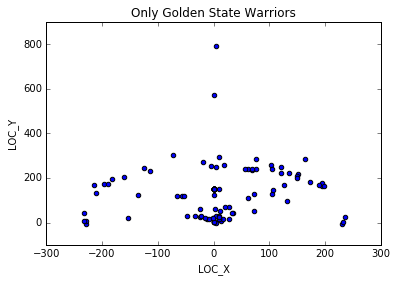

In [35]:
'''
Now look at just the Cleveland Cavaliers Shots
'''
team1, team2 = df_all['TEAM_NAME'].unique()
df_all[df_all['TEAM_NAME'] == team1].plot.scatter('LOC_X', 'LOC_Y', title="Only " + team1);

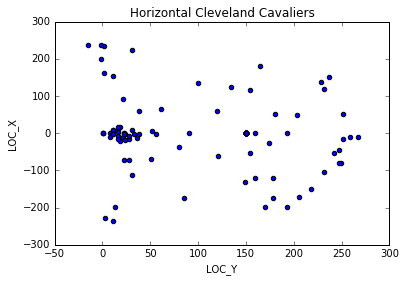

In [36]:
'''
The plots look fine but maybe it would be better if we reversed the X and Y positions so that we can view the shots
how we normally would from TV
'''
df_all[df_all['TEAM_NAME'] == team2].plot.scatter('LOC_Y', 'LOC_X', title= "Horizontal " + team2);

## Finding the home team
Finding the home team is not obvious. A hacky solution is prsented below. We simply use as home team the more frequent time the 'HOMEDESCRIPTION' column is used in the play by play DataFrame.

In [37]:
'''
This is hacky but works for finding both home and visiting team.

The 'apply' method in DataFrames is used to iterate over each row/column and apply a function with the
values of that row/column.

Here, the apply function is used to return True if the HOMEDESCRIPTION column is not null and 
the VISITORDESCRIPTION is null. This result is used to boolean slice the DataFrame and then find the most
frequent team (found when concatenating PLAYER1_TEAM_CITY and PLAYER1_TEAM_NICKNAME).

This should always yield the home team. Please let me know if you find a better method
'''
home_team_df = df_play_by_play[df_play_by_play.apply(lambda row: row['HOMEDESCRIPTION'] is not None 
                              and row['VISITORDESCRIPTION'] is None, axis=1)][['PLAYER1_TEAM_CITY', 'PLAYER1_TEAM_NICKNAME']]

home_team_ser = home_team_df['PLAYER1_TEAM_CITY'] + ' ' + home_team_df['PLAYER1_TEAM_NICKNAME']
home_team = home_team_ser.value_counts().index.values[0]

In [38]:
'''
Create indicator (1/0) column for home team and get visiting team name
'''
df_all['HOME_TEAM'] = (df_all['TEAM_NAME'] == home_team) * 1
visitor_team = df_all[df_all['HOME_TEAM'] == 0]['TEAM_NAME'].values[0]

## Adding the description of the event
In the play by play DataFrame, there is a column that gives more detail on the outcome of the event. This description might be useful to display during the animation to give the user information on exactly what is happening. Since, both teams can be involved in the event there are both **HOMEDESCRIPTION** and **VISITORDESCRIPTION** columns. We first shrink the play by play DataFrame to only **EVENTNUM** and both descsriptions. We then merge (similar to a SQL join) this table to our full table, **df_all** and finally only use the description that corresponds to the team attempting to score.

In [39]:
'''
Tack on a column for the description.
'''
df_description = df_play_by_play[['EVENTNUM', 'HOMEDESCRIPTION', 'VISITORDESCRIPTION']]
df_all = pd.merge(df_all, df_description, how='left', left_on='GAME_EVENT_ID', right_on='EVENTNUM')
df_all['DESCRIPTION'] = df_all.apply(lambda row: row['HOMEDESCRIPTION'] if row['HOME_TEAM'] else 
                                                    row['VISITORDESCRIPTION'], axis=1)

## Missing Description for Free Throws
Since free throws were retreived using the play by play endpoint, there was no corresponding description. We follow convention (from the df_shots DataFrame) and manually create a description

In [40]:
'''
Fill the missing description values with a simple manually created description
'''
df_all['DESCRIPTION'] = df_all['DESCRIPTION'].fillna(df_all.apply(lambda row: row['PLAYER_NAME'] + ' Free Throw' 
                                          if row['SHOT_MADE_FLAG'] else 'MISS ' + row['PLAYER_NAME'] + ' Free Throw', axis=1))

In [41]:
'''
Remove superfluous columns
'''
df_all = df_all.drop(['EVENTNUM', 'VISITORDESCRIPTION', 'HOMEDESCRIPTION'], axis=1)

## Examining Shot Locations
Looking at the range of **LOC_X** and **LOC_Y** columns it seems apparent that the dimensions are feet multiplied by 10 since a basketball court is 94ft long by 50ft wide. 

Since, there are negative values for **LOC_X** some more investigation yields that the actual basket is located at **LOC_X** equal to 0. The actual basket is 4 feet from the edge of the court (-40 for **LOC_X**). This means the max value for **LOC_X** would be 900.

## Transforming Court Dimensions
The same values for **LOC_X** and **LOC_Y** are used regardless of the team. To animate a game, we need to translate the shots of one team over to the other side of the court.

In [42]:
'''
Switch X and Y coordinates so that the court matches what you would see on TV
Move one team's shots over to the other side of the court
Add 40 to each LOC_X_NEW to remove negative values
'''
df_all['LOC_X_NEW'] = df_all.apply(lambda x: x['LOC_Y'] if x['HOME_TEAM'] == 1 else 860 - x['LOC_Y'], axis=1) + 40
df_all['LOC_Y_NEW'] = df_all['LOC_X']

## Order each shot by time left in game
Since free throws were not originally in the data, we need to sort the df_all DataFrame by number of seconds remaining in the game.

In [43]:
'''
Create a new column that contains the number of seconds elapsed in game
'''
df_all['SEQUENTIAL_SECONDS'] = 720 * (df_all['PERIOD'] - 1) + 720 - (df_all['MINUTES_REMAINING'] * 60 + df_all['SECONDS_REMAINING'])
df_all.sort_values('SEQUENTIAL_SECONDS', inplace=True)
df_all.reset_index(drop=True, inplace=True)

In [44]:
'''
Take a peak at the last record
'''
df_all.iloc[-1]

ACTION_TYPE                             Free Throw
EVENT_TYPE                               Made Shot
GAME_EVENT_ID                                   -1
GAME_ID                                 0041500405
GRID_TYPE                        Shot Chart Detail
LOC_X                                            0
LOC_Y                                          150
MINUTES_REMAINING                                1
PERIOD                                           4
PLAYER_ID                                     2760
PLAYER_NAME                       Anderson Varejao
SECONDS_REMAINING                                1
SHOT_ATTEMPTED_FLAG                              1
SHOT_DISTANCE                                   15
SHOT_MADE_FLAG                                   1
SHOT_TYPE                               Free Throw
SHOT_ZONE_AREA                          Free Throw
SHOT_ZONE_BASIC                         Free Throw
SHOT_ZONE_RANGE                             15 ft.
TEAM_ID                        

## Build Static Visualization
We now have enough information to recreate the image at the very top of the page provided by basketballreference.com. We will first build the court using lines, arcs and circles from matplotlib and then place some colored scattered circular mark to indicate both the team and whether the shot was made. We can also remove the ugliness of the default matplotlib settings and import the **seaborn** package which among other things, instantly beautifies your plot.

In [45]:
from matplotlib.patches import Arc, Circle
import seaborn
import numpy as np

In [46]:
'''
Add supplementary columns for color of shot and whether to have scatterplot circle filled (for a maker) 
or hollow (for a miss)
'''
df_all['FACECOLOR'] = df_all.apply(lambda row: 'none' if row['SHOT_MADE_FLAG'] == 0 else 'r' if row['HOME_TEAM'] else 'g', axis=1)
df_all['EDGECOLOR'] = df_all['HOME_TEAM'].map(lambda x: 'r' if x else 'g')

## Create the court
A great tutorial on creating an NBA court with shots [can be viewed here](http://savvastjortjoglou.com/nba-shot-sharts.html)

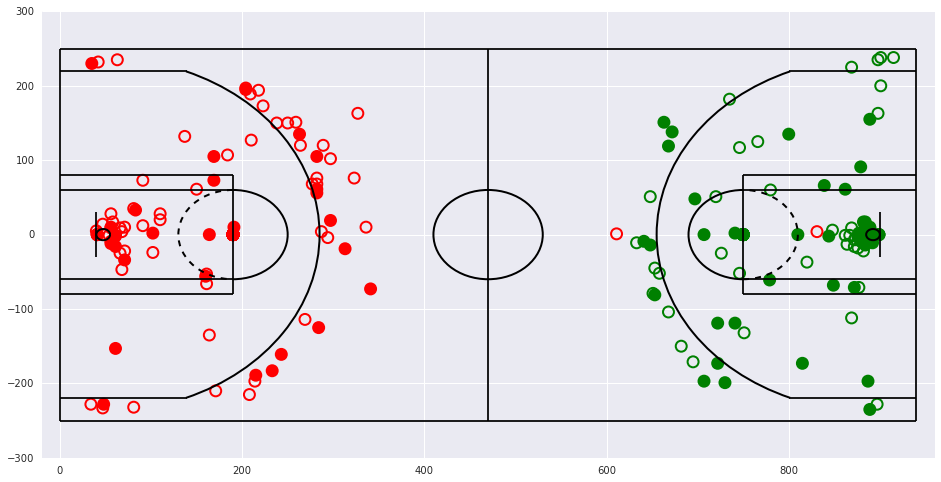

In [47]:
'''
There are a number of ways to begin creating a plot. In matplotlib, the outer frame of the plot is called the figure
and usually abbreviated fig. An 'axes' is the actual plot inside a figure that is being created. There can be multiple
axes within a single figure, though in this example there will be only one
'''
# Create a single figure with one axes. Give dimensions to figure
fig, ax = plt.subplots(figsize=(16,8))

# Draw the borders of the court
ax.set_xlim(-20, 960)
ax.vlines([0, 940], -250, 250)
ax.hlines([-250, 250], 0, 940)
ax.hlines([-80, -80, 80, 80], [0, 750] * 2, [190, 940] * 2)
ax.hlines([-60, -60, 60, 60], [0, 750] * 2, [190, 940] * 2)
ax.vlines([190, 750], -80, 80)
ax.vlines(470, -250, 250)
ax.vlines([40, 900], -30, 30)

# Add the three point arc, free throw circle, midcourt circle and backboard and rim
ax.add_patch(Arc((190, 0), 120, 120, theta1=-90, theta2=90, linewidth=2))
ax.add_patch(Arc((190, 0), 120, 120, theta1=90, theta2=-90, linewidth=2, linestyle='dashed'))
ax.add_patch(Arc((750, 0), 120, 120, theta1=90, theta2=-90, linewidth=2))
ax.add_patch(Arc((750, 0), 120, 120, theta1=-90, theta2=90, linewidth=2, linestyle='dashed'))
ax.hlines([-220, -220, 220, 220], [0, 800] * 2, [140, 940] * 2)
ax.add_patch(Arc((47.5, 0), 475, 475, theta1=-67.5, theta2=67.5, linewidth=2))
ax.add_patch(Arc((892.5, 0), 475, 475, theta1=112.5, theta2=-112.5, linewidth=2))
ax.add_patch(Arc((47.5, 0), 15, 15, theta1=0, theta2=360, linewidth=2))
ax.add_patch(Arc((892.5, 0), 15, 15, theta1=0, theta2=360, linewidth=2))
ax.add_patch(Circle((470, 0), 60, facecolor='none', lw=2))

# Finally add the shots
ax.scatter('LOC_X_NEW', 'LOC_Y_NEW', marker='o', s=120, facecolors='FACECOLOR', edgecolors='EDGECOLOR', lw=2, data=df_all);

## Animation
For animation to occur in matplotlib in the iPython notebook two things must occur. First, the magic command %matplotlib notebook must be run. This changes matplotlib's backend to **nbagg** which allows for interactive plots. Second, the **FuncAnimation** function must be imported which utilizes a user-defined function to control the objects in the plot.

In [48]:
'''
Allow notebook to have interactive plots
'''
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from matplotlib.animation import writers

<IPython.core.display.Javascript object>


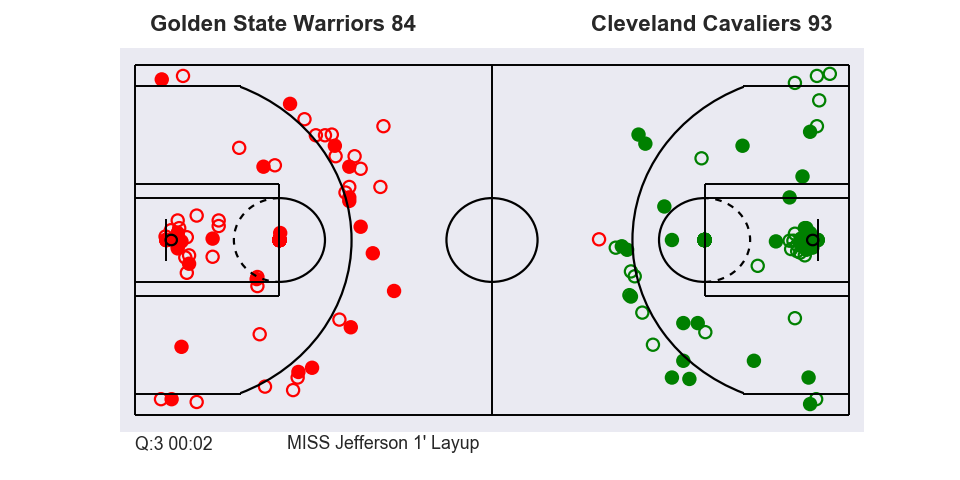

In [49]:
# Recreate the court
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(-20, 960)
ax.vlines([0, 940], -250, 250)
ax.hlines([-250, 250], 0, 940)
ax.hlines([-80, -80, 80, 80], [0, 750] * 2, [190, 940] * 2)
ax.hlines([-60, -60, 60, 60], [0, 750] * 2, [190, 940] * 2)
ax.vlines([190, 750], -80, 80)
ax.vlines(470, -250, 250)
ax.vlines([40, 900], -30, 30)
ax.add_patch(Arc((190, 0), 120, 120, theta1=-90, theta2=90, linewidth=2))
ax.add_patch(Arc((190, 0), 120, 120, theta1=90, theta2=-90, linewidth=2, linestyle='dashed'))
ax.add_patch(Arc((750, 0), 120, 120, theta1=90, theta2=-90, linewidth=2))
ax.add_patch(Arc((750, 0), 120, 120, theta1=-90, theta2=90, linewidth=2, linestyle='dashed'))
ax.hlines([-220, -220, 220, 220], [0, 800] * 2, [140, 940] * 2)
ax.add_patch(Arc((47.5, 0), 475, 475, theta1=-67.5, theta2=67.5, linewidth=2))
ax.add_patch(Arc((892.5, 0), 475, 475, theta1=112.5, theta2=-112.5, linewidth=2))
ax.add_patch(Arc((47.5, 0), 15, 15, theta1=0, theta2=360, linewidth=2))
ax.add_patch(Arc((892.5, 0), 15, 15, theta1=0, theta2=360, linewidth=2))
ax.add_patch(Circle((470, 0), 60, facecolor='none', lw=2))

# Clean the court by removing the tick marks
ax.set_xticks([])
ax.set_yticks([])

# Create a dictionary to keep track of the score. 1 is the home team
scores = {0: 0, 1: 0}

# Assign to variables the plot items that will change after each iteration
home_text = ax.text(20, 300, home_team + " " + str(scores[0]), fontsize=20, fontweight='bold')
vis_text = ax.text(600, 300, visitor_team + " " + str(scores[1]), fontsize=20, fontweight='bold')
time_left = ax.text(0, -300, "Q:1 12:00", fontsize= 16)
description = ax.text(200, -300, "", fontsize= 16)

sizes = np.zeros(len(df_all))

# Initialize plot with all 0 size
shot_scatter = ax.scatter('LOC_X_NEW', 'LOC_Y_NEW', marker='o', sizes=sizes,
                          facecolors='FACECOLOR', edgecolors='EDGECOLOR', lw=2, data=df_all);

def init():
    scores = {0: 0, 1: 0}
    


# The update function is called as frequently as the interval parameter below (in milliseconds).
def update(frame_number):
    # Make the current point visible
    sizes[:frame_number + 1] = 120
    shot_scatter.set_sizes(sizes)
    
    # Change the score
    current_row = df_all.iloc[frame_number]
    scores[current_row['HOME_TEAM']] += current_row['POINTS']
    home_text.set_text(home_team + " " + str(scores[1]))
    vis_text.set_text(visitor_team + " " + str(scores[0]))
    
    time_left.set_text("Q:{} {:02d}:{:02d}".format(current_row['PERIOD'], 
                                                                   current_row['MINUTES_REMAINING'],
                                                                   current_row['SECONDS_REMAINING']))
    description.set_text(current_row['DESCRIPTION'])
    
    if frame_number == len(sizes) - 1:
        sizes[:] = 0
        scores[0] = 0
        scores[1] = 0

# Writer = writers['ffmpeg']
# writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

animation = FuncAnimation(fig, update, len(sizes), interval=300, init_func=init, blit=True)
file_name = 'temp_bball.mp4' 
animation.save(file_name, fps=3, extra_args=['-vcodec', 'libx264'])

http://stackoverflow.com/questions/18019477/how-can-i-play-a-local-video-in-my-ipython-notebook

In [50]:
import io
import base64

In [51]:
video = io.open(file_name, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))